In [1]:
import numpy as np
import os
from scipy.misc import comb
from scipy.stats import norm
import pickle
import operator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
if not os.path.isdir("histplots"):
    os.mkdir("histplots")

### Create Entner Baseline helper functions

In [4]:
# code inspired by makeDecisionAndEstimateEffect_3classes.m AND 
# calculateEstimatedEffect.m
# INPUT
# data
# D (n,d+3)... data matrix
#   (n,d)  ... Z covariates
#   (n,)   ... W auxiliary variable
#   (n,)   ... X treatment
#   (n,)   ... Y outcome
# datatype ... string: 'continuous' if data are Gaussain
#                      'discrete' if data are discrete
# p_vals_wy_zx ... p-values from tests
# p_vals_wy_z  ... p-values from tests
# Zsels  ... selected Zs
#
# OUTPUT
# est ... estiamte of the causal effect of x on y, or NaN
# Dec ... decision: 1 for D1, 2 for D2, 3 for D3, 4 if Decision from Naive
#         Bayes classifier was D1, but estimates were not similar enough, so
#         we do not give an estimate of the causal effect of x on y, i.e. est
#         is the following depending on Dec:
#         if Decision is D1 (i.e. Dec=1) est is the estimate of the non-zero
#         effect of x on y. For D2 (i.e. Dec=2), est = 0; For D3 (i.e.
#         Dec=3), or Dec=4, est = NaN;
# post_prob = class posterior probabilities of D1, D2, and D3 (in this order)
def estimate_effects(D, datatype, p_vals_wy_zx, p_vals_wy_z, Zsels):

    (n,d3) = D.shape
    ixY    = d3-1
    ixX    = d3-2
    ixW    = d3-3
    ixZ    = np.arange(d3-3)
    d      = d3-3
    t      = p_vals_wy_zx.shape[0]
    p_reject = 0.001
    p_accept = 0.1
    # if datatype == 'continuous':
    # 	# assuming n >= 5000
    # 	p_reject = 0.001
    # 	p_accept = 0.1
    # elif datatype == 'discrete':
    # 	itest = 'logOdds'
    # 	cov = D
    # else:
    # 	error('no such datatype')

    # NOTE: we do not use this code as it is only to check if R1 or R2/R3 
    #       applies (we assume R3 applies) 
    # getCountsFromPvalues.m
    # ----------------------
    # cntR3 = sum( temp{3}(:,2) > p_accept & temp{3}(:,3) < p_reject)
    # cntR3 = np.sum(p_vals_wy_zx > p_accept & p_vals_wy_z < p_reject)
    # cntR3_norm = cntR3/t

    # calculateEstimatedEffect.m
    # --------------------------
    bool = np.logical_and((p_vals_wy_zx > p_accept),(p_vals_wy_z < p_reject))
    Zaccept = np.array(Zsels)[bool]
    times = Zaccept.shape[0]

    if datatype == 'continuous':
        b = np.ones((n,1))
        Dx = D[:,ixX].reshape((n,1))
        Dy = D[:,ixY].reshape((n,1))
        if times == 0:
            X = np.concatenate((b, Dx), axis=1)
            C = np.dot(X.transpose(), X)
            Xy= np.dot(X.transpose(), Dy)
            theta = np.linalg.solve(C, Xy)
            ate = theta[1]
        else:
            ate = np.zeros((times,))
            for i in range(times):
                Z = Zaccept[i]
                if Z.shape[0] == 0:
                    X = np.concatenate((b, Dx), axis=1)
                else:
                    X = np.concatenate((b, Dx, D[:,Z]), axis=1)
                    # (X'X)^-1(X'y)
                C = np.dot(X.transpose(), X)
                Xy= np.dot(X.transpose(), Dy)
                theta = np.linalg.solve(C, Xy)
                # NOTE: we do not check if estimates are similar
                # and output NaN if so, as in the original
                #       code via:
                # val = areEstiamtesSimilar_Clusters(ests, CIs);
                ate[i] = theta[1]
    elif datatype == 'discrete':
        error('not implemented')
    else:
        error('no such datatype')

    return ate


# code inspired by algorithm_applyRules123_random.m
# NOTE from entner!
# NOTE: in the comments of the code, the rule numbers do not match the ones in
  # the paper. (We changed themw later on in the article, apologies for any 
  # inconveniences.) Here is the correspondence between the rules:

  # article               code
  # R1 (i) + (ii)         R3 (iii) + (ii) (Note R3(i) in code is not used)
  # R2 (i)                R1
  # R2 (ii) + (iii)       R2
# INPUT
# data
# D (n,d+3)... data matrix
#   (n,d)  ... Z covariates
#   (n,)   ... W auxiliary variable
#   (n,)   ... X treatment
#   (n,)   ... Y outcome
# datatype ... string: 'continuous' if data are Gaussain
#                      'discrete' if data are discrete
# k        ... maximal size of conditioning set in independence test
# t        ... how many tests are performed, i.e. how often do we
#                     select a random set Z (and w) and perform test
# 
# OUTPUT
# p_vals ... p-values from tests
# Zsels  ... selected Zs
def Zsel_highdim(D, datatype, k, t):

    (n,d3) = D.shape
    ixY    = d3-1
    ixX    = d3-2
    ixW    = d3-3
    ixZ    = np.arange(d3-3)
    d      = d3-3

    if datatype == 'continuous':
        itest = 'partialCorr'
        cov = np.cov(D.transpose())
    elif datatype == 'discrete':
        itest = 'logOdds'
        cov = D
    else:
        error('no such datatype')

    n_R3_cardZ = np.zeros((k+1,1)) # how many sets of each conditioning size up to K
    for i in range(k+1):
        n_R3_cardZ[i] = comb(d,i)

    # cumulative proportions of conditioing sets of size 0,...,K, for one w
    cumprop_R3 =  np.cumsum(n_R3_cardZ) / np.sum(n_R3_cardZ); 


    # save things
    Zsels = []
    p_vals_wy_zx = np.zeros((t,))
    p_vals_wy_z  = np.zeros((t,))

    rand_r = np.random.random(size=t)
    for i in range(t):
        #w = rand_d[i]
        r   = rand_r[i]
        cardZ = np.argmin(cumprop_R3 < r) # find the sampled bin
        #Ww = np.setdiff1d(W,w)
        temp = np.random.permutation(d)
        ix_Zsel = np.sort(temp[:cardZ])

        # condition 2 of R3: w indep y given Z and x
        pval_wy_ZX_R3 = indepTest(ixW, ixY, np.append(ix_Zsel,ixX), n, cov, itest);

        # condition 3 of R3: w not indep y given Z
        pval_wy_Z_R3 = indepTest(ixW, ixY, ix_Zsel, n, cov, itest);

        p_vals_wy_zx[i] = pval_wy_ZX_R3
        p_vals_wy_z[i]  = pval_wy_Z_R3
        Zsels.append(ix_Zsel)
    return p_vals_wy_zx, p_vals_wy_z, Zsels



def indepTest(ixA, ixB, ixZ, n, C, itest):
    if itest == 'partialCorr':
        ixAB = np.array([ixA,ixB])
        #        C(indAB,indAB) - C(indAB,ixZ) * C(ixZ,ixZ)^(-1) * C(ixZ,indAB)
        C_cond = C[ixAB,:][:,ixAB] - np.dot(C[ixAB,:][:,ixZ], np.linalg.solve(C[ixZ,:][:,ixZ], C[ixZ,:][:,ixAB]))
        # test if partial correlation is statistically significantly different
        # from 0 (using Fisher's Z, see Spirtes et al. p.94); if not, independence
        r = C_cond[0,1]
        fisherZ = 0.5* np.sqrt(n - ixZ.shape[0] - 3) * np.log(np.abs(1+r) / np.abs(1-r));
        p = 2*(1-norm.cdf(np.abs(fisherZ)));
    elif itest == 'logOdds':
        error('not implemented yet')
        #[pval_g, pval_chi] = gsquare_test(DataCov,states,w,x,Z);
        #p = pval_g;
    return p

# NOTE: DON'T USE THIS, JUST FOR TESTING
def depricated_sampling(n):
    z_dim = 30
    u_dim = 30
    a,b,c,d,e,l = np.random.normal(0,1,6)
    f,g,h,j,k = np.random.normal(0,1,size=(5,z_dim))

    D = np.zeros((n,z_dim*4+3))
    for i in range(n):
        W  = np.random.normal(0,1)
        U1 = np.random.normal(0,1,u_dim)
        U2 = np.random.normal(0,1,u_dim)
        Z1 = a*U1 + b*U2 + c*W + np.random.normal(0,.5,z_dim)
        Z2 = d*W  + np.random.normal(0,.5,z_dim)
        Z3 = np.random.normal(0,1,z_dim)
        Z4 = np.random.normal(0,1,z_dim)
        X = e*W + np.dot(f,U1) + np.dot(g,Z2) + np.dot(h,Z3) + np.random.normal(0,.5)
        Y = np.dot(j,Z3) + np.dot(k,Z4) + l*X + np.random.normal(0,.5)
        D[i,:z_dim] = Z1
        D[i,z_dim:z_dim*2] = Z2
        D[i,z_dim*2:z_dim*3] = Z3
        D[i,z_dim*3:z_dim*4] = Z4
        D[i,z_dim*4] = W
        D[i,z_dim*4+1] = X
        D[i,z_dim*4+2] = Y
    return D, l

def run(D):
    datatype = 'continuous' # Entner only have code for continuous data
    k = 30   # maximal size of conditioning set (Z3 is true set)
    t = 1000 # tests
    p_vals_wy_zx, p_vals_wy_z, Zsels = Zsel_highdim(D, datatype, k, t)
    ate = estimate_effects(D, datatype, p_vals_wy_zx, p_vals_wy_z, Zsels)
    return ate, np.median(ate)

### Plotting helper functions

In [5]:
len_of_trial = 25

def Entner_ATE(path):
    entner_train_ATE_errs = []
    entner_valid_ATE_errs = []
    for i in range(1,26):
        with open(path+'/outputfiles/train_data_'+str(i)+'.pickle', 'rb') as pickle_file:
            train_D = pickle.load(pickle_file)
        with open(path+'/outputfiles/valid_data_'+str(i)+'.pickle', 'rb') as pickle_file:
            valid_D = pickle.load(pickle_file)
        with open(path+'/outputfiles/train_real_ATE_'+str(i)+'.pickle', 'rb') as pickle_file:
            l_train = pickle.load(pickle_file)
        with open(path+'/outputfiles/valid_real_ATE_'+str(i)+'.pickle', 'rb') as pickle_file:
            l_valid = pickle.load(pickle_file)

        ate_all_train, ate_median_train = run(train_D)
        ate_all_valid, ate_median_valid = run(valid_D)
        err_train = np.abs(ate_median_train - l_train)
        err_valid = np.abs(ate_median_valid - l_valid)
        entner_train_ATE_errs.append(err_train)
        entner_valid_ATE_errs.append(err_valid)
        
    return entner_train_ATE_errs, entner_valid_ATE_errs

def retrieve_ATE_results(path):
    f = open(path+"/results/ATE_Bs_full.txt", "r")
    string_example = f.read()
    string_example = string_example.replace("Dict(", "")
    string_example = string_example.replace(")", "")
    string_example = string_example.replace(" => ", "")

    list_string = string_example.split(',"')
    list_string[0] = list_string[0][1:]

    dict_results = {}
    for l in list_string:
        curr_list_string = l.split('"')
        dict_results[curr_list_string[0]] = \
        [round(float(x), 7) for x in curr_list_string[1].replace("[", "").replace("]", "").split(", ")]

    return dict_results

def construct_ATE_df(entner_train, entner_valid, ATE_dict):
    df = pd.DataFrame({"type": ["Entner"]*len_of_trial+["Entner"]*len_of_trial+
                          ["Our method"]*len_of_trial+["Our method"]*len_of_trial+
                          ["Our method Zsel"]*len_of_trial+["Our method Zsel"]*len_of_trial+
                          ["Marg"]*len_of_trial+["Marg"]*len_of_trial+
                          ["allZ"]*len_of_trial+["allZ"]*len_of_trial,
                   "valid_train": ["train"]*len_of_trial + ["valid"]*len_of_trial+
                          ["train"]*len_of_trial+["valid"]*len_of_trial+
                          ["train"]*len_of_trial+["valid"]*len_of_trial+
                          ["train"]*len_of_trial+["valid"]*len_of_trial+
                          ["train"]*len_of_trial+["valid"]*len_of_trial,
                   "ATE_error": entner_train+entner_valid+
                        ATE_dict["err_learned_train"]+ATE_dict["err_learned_valid"]+
                        ATE_dict["err_zsel_learned_train"]+ATE_dict["err_zsel_learned_valid"]+
                        ATE_dict["err_marg_Z_train"]+ATE_dict["err_marg_Z_valid"]+
                        ATE_dict["err_all_Z_train"]+ATE_dict["err_all_Z_valid"]})

    df_just_valid = df[df["valid_train"]=="valid"]
    df_just_valid = df_just_valid[df_just_valid["type"]!="Our method"]

    return df_just_valid
    
def vertical_median_line(x, offset=0.005, fontsize=16, pos=8, **kwargs):
    median = x.median()
    plt.axvline(median, linestyle = '--', color = 'black')
    plt.text(median+offset, pos, str(round(median, 3)), rotation=90, fontsize=fontsize, color='black')
    
    
def hist_ATE_plot(df, name, offset=0.005, fontsize=16, pos=8):
    g = sns.FacetGrid(df, row="type",
                  height=4, aspect=4, hue="type", 
                  row_order=["Entner", "Marg", "allZ", "Our method Zsel"],
                  hue_kws={'color': ['sandybrown', 'royalblue' ,'firebrick', 'mediumseagreen']})

    g.map(sns.distplot, "ATE_error", hist_kws=dict(alpha=.3),kde = False);
    g.fig.set_figheight(8)
    g.fig.set_figwidth(10)
    g.map(vertical_median_line, "ATE_error", offset=offset, fontsize=fontsize, pos=pos)

    xlbel = "ATE error"
    g.set_xlabels(xlbel,fontsize=17)
    ylbel = "Count"
    titles =  ["Entner et al., 2013", "Marginal", "all Z", "Ours"]
    for i, ax in enumerate(g.axes.flatten()):
        ax.tick_params(labelbottom=True)
        ax.tick_params(labelsize=17)

        ax.set_ylabel(ylbel,fontsize=17)
        ax.set(ylim=(0.0, 12))
        ax.set_title(titles[i],fontsize=18, weight='bold')
        for _, spine in ax.spines.items():
            spine.set_visible(True) 
            spine.set_color('gainsboro')
            spine.set_linewidth(5)

    plt.subplots_adjust(hspace=0.7)
    g.savefig("histplots/"+name+"_valid.png")

## Treatment effect (omega = 0.1)

### hard allZ case (sigma_squared_x = 0.01)

Computed in parallel on server with seeding by trial num (see instructions in Compute_ATEs_produce_scatterplots_julia.ipynb)

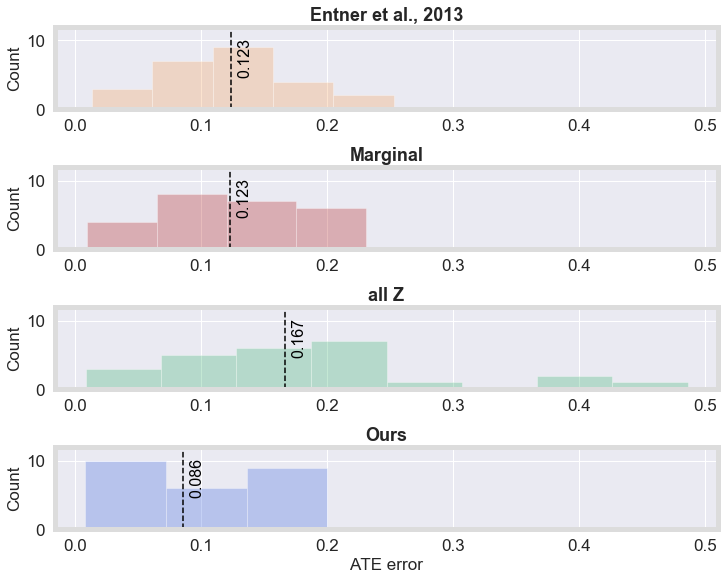

In [6]:
entner_train_hardallZ_xeffect_point1, entner_valid_hardallZ_xeffect_point1 = Entner_ATE("../../code/omega_point_1_sigma2_point_01")
dict_hardallZ_xeffect_point1 = retrieve_ATE_results("../../code/omega_point_1_sigma2_point_01")
df_hardallZ_xeffect_point1 = construct_ATE_df(entner_train_hardallZ_xeffect_point1, entner_valid_hardallZ_xeffect_point1, dict_hardallZ_xeffect_point1)

hist_ATE_plot(df_hardallZ_xeffect_point1, "omega_point_1_sigma2_point_01", offset=0.005, fontsize=16, pos=5)

### hard marginal case (sigma_squared_x = 0.6)

Computed in parallel on server with seeding by trial num

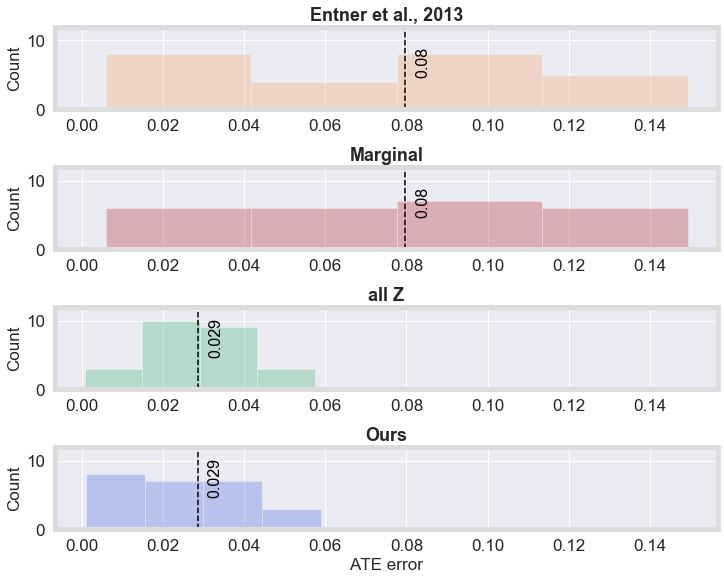

In [7]:
entner_train_hardmarg_xeffect_point1, entner_valid_hardmarg_xeffect_point1 = Entner_ATE("../../code/omega_point_1_sigma2_point_6")
dict_hardmarg_xeffect_point1 = retrieve_ATE_results("../../code/omega_point_1_sigma2_point_6")
df_hardmarg_xeffect_point1 = construct_ATE_df(entner_train_hardmarg_xeffect_point1, entner_valid_hardmarg_xeffect_point1, dict_hardmarg_xeffect_point1)

hist_ATE_plot(df_hardmarg_xeffect_point1, "omega_point_1_sigma2_point_6", offset=0.0025, fontsize=16, pos=5)

## Treatment effect (omega = 0.5)

### hard allZ case (sigma_squared_x = 0.01)

Computed in parallel on server with seeding by trial num

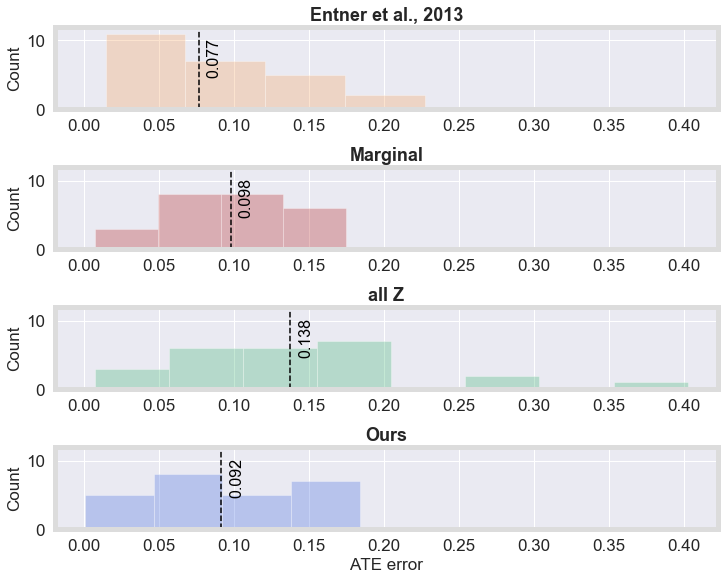

In [8]:
entner_train_hardallZ_xeffect_point5, entner_valid_hardallZ_xeffect_point5 = Entner_ATE("../../code/omega_point_5_sigma2_point_01")
dict_hardallZ_xeffect_point5 = retrieve_ATE_results("../../code/omega_point_5_sigma2_point_01")
df_hardallZ_xeffect_point5 = construct_ATE_df(entner_train_hardallZ_xeffect_point5, entner_valid_hardallZ_xeffect_point5, dict_hardallZ_xeffect_point5)

hist_ATE_plot(df_hardallZ_xeffect_point5, "omega_point_5_sigma2_point_01", offset=0.005, fontsize=16, pos=5)

### hard marginal case (sigma_squared_x = 0.6)

Computed in parallel on server with seeding by trial num

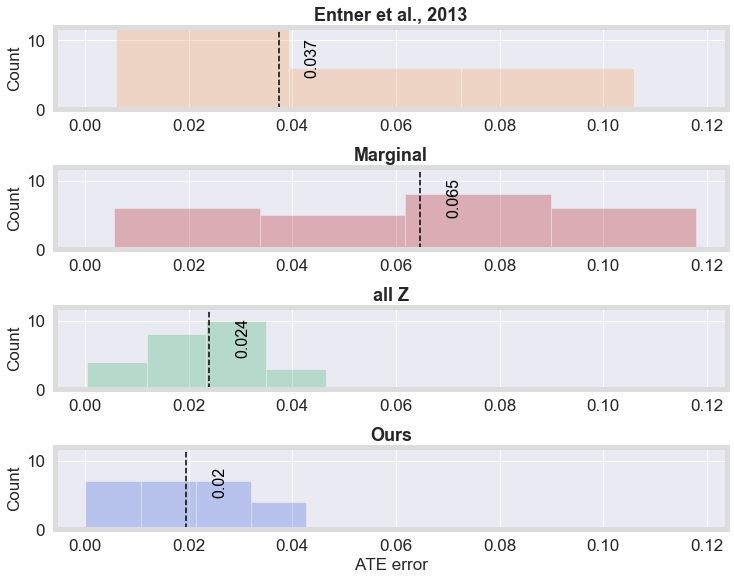

In [9]:
entner_train_hardmarg_xeffect_point5, entner_valid_hardmarg_xeffect_point5 = Entner_ATE("../../code/omega_point_5_sigma2_point_6")
dict_hardmarg_xeffect_point5 = retrieve_ATE_results("../../code/omega_point_5_sigma2_point_6")
df_hardmarg_xeffect_point5 = construct_ATE_df(entner_train_hardmarg_xeffect_point5, entner_valid_hardmarg_xeffect_point5, dict_hardmarg_xeffect_point5)

hist_ATE_plot(df_hardmarg_xeffect_point5, "omega_point_5_sigma2_point_6", offset=0.005, fontsize=16, pos=5)